<a href="https://colab.research.google.com/github/kashishthakur26/Natural_language_processing/blob/main/BERT_for_Disaster_Tweets_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np

import re
import string
import os

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

plt.style.use('ggplot')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense , SpatialDropout1D , Dropout
from tensorflow.keras.optimizers import Adam

In [5]:
##import dataset from github
tweet = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/twitter-disaster-prediction-dataset/master/train.csv')

In [6]:
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [12]:
tweet.

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [11]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### Exploratory Data Analysis

#### Target class distribution

In [9]:
plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['figure.dpi'] = 80

Text(0.5, 1.0, 'Real or Not Real disaster Tweet')

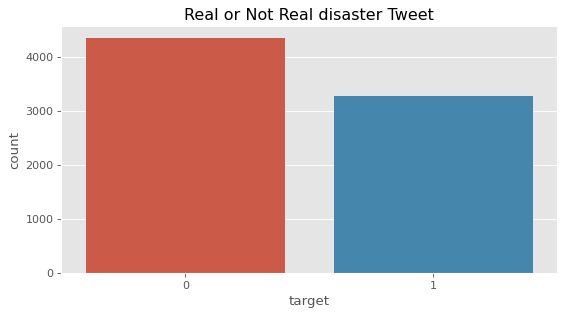

In [13]:
sns.countplot(data=tweet, x='target')
plt.title('Real or Not Real disaster Tweet')


In [14]:
tweet['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

<Axes: ylabel='target'>

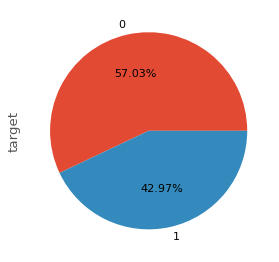

In [15]:
tweet['target'].value_counts().plot.pie(autopct='%1.2f%%')

In [16]:
## importing preprocess_package_from github
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-9ly3c1qn
  Running command git clone --filter=blob:none --quiet https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-9ly3c1qn
  Resolved https://github.com/laxmimerit/preprocess_kgptalkie.git to commit 9ca68d37027af9f6a30d54640347ce3b2e2694b3
  Preparing metadata (setup.py) ... done
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=7621 sha256=c08cd285b2fa7c2f2efc304235ed14e23b8650ce4b752e1319dbba24ca6739b2
  Stored in directory: /tmp/pip-ephem-wheel-cache-2v__pji2/wheels/5c/94/34/99d5ff65e88b8d9a6c5e8d8652f2311d87790a61a1b7466e21
Successfully built preprocess-kgptalkie


In [20]:
import preprocess_kgptalkie as pp

In [21]:
tweet = pp.get_basic_features(tweet)

In [22]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,72,16,4.500000,6,2,0,0,0


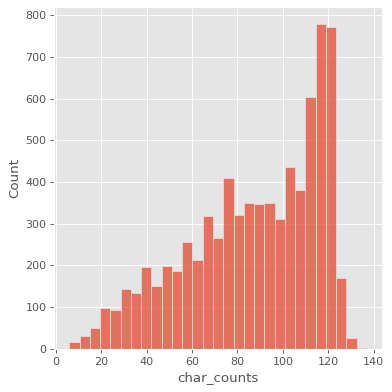

In [23]:
sns.displot(tweet['char_counts'])

<ipython-input-24-7433aa2a83b9>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tweet['char_counts'], shade=True)


<Axes: xlabel='char_counts', ylabel='Density'>

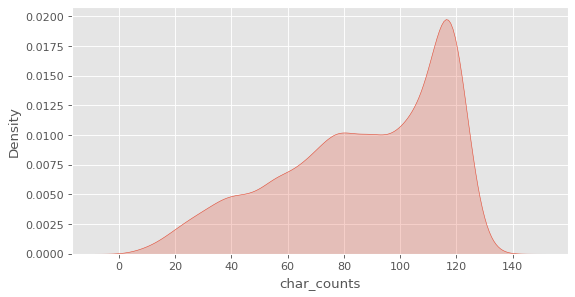

In [24]:
sns.kdeplot(tweet['char_counts'], shade=True)

<ipython-input-25-4c013d23f0f8>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tweet[tweet['target']==1]['char_counts'], shade=True, color='red')
<ipython-input-25-4c013d23f0f8>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tweet[tweet['target']==0]['char_counts'], shade=True, color='blue')


<Axes: xlabel='char_counts', ylabel='Density'>

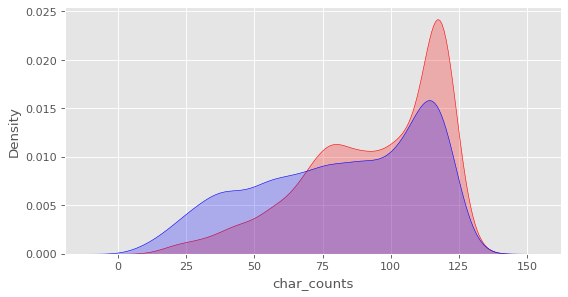

In [25]:
sns.kdeplot(tweet[tweet['target']==1]['char_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['char_counts'], shade=True, color='blue')

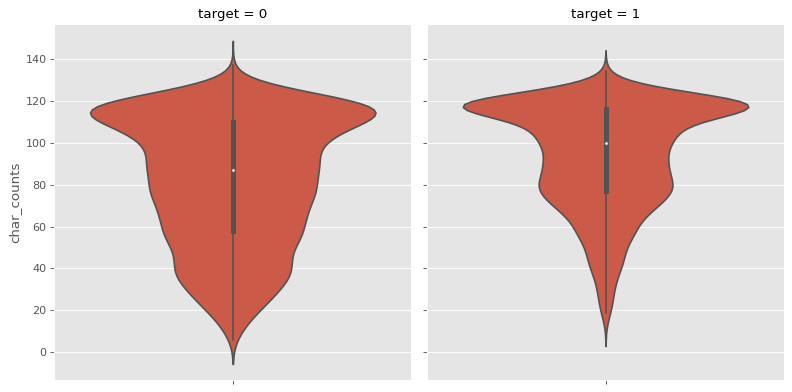

In [26]:
sns.catplot(y='char_counts', data=tweet, kind='violin', col='target')

#### Number of words average words length and stop words distribution in tweets

<ipython-input-27-48b4fde55523>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tweet[tweet['target']==1]['word_counts'], shade=True, color='red')
<ipython-input-27-48b4fde55523>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tweet[tweet['target']==0]['word_counts'], shade=True, color='magenta')


<Axes: xlabel='word_counts', ylabel='Density'>

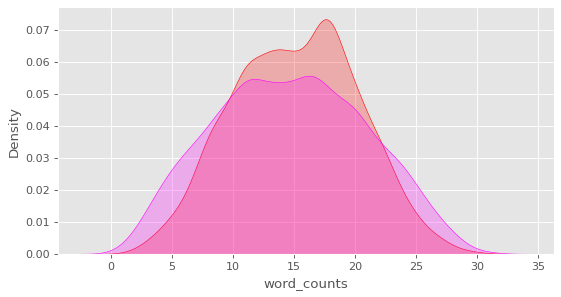

In [27]:
sns.kdeplot(tweet[tweet['target']==1]['word_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['word_counts'], shade=True, color='magenta')


<ipython-input-28-0ecd8b72bcb9>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tweet[tweet['target']==1]['avg_wordlength'], shade=True, color='red')
<ipython-input-28-0ecd8b72bcb9>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tweet[tweet['target']==0]['avg_wordlength'], shade=True, color='magenta')


<Axes: xlabel='avg_wordlength', ylabel='Density'>

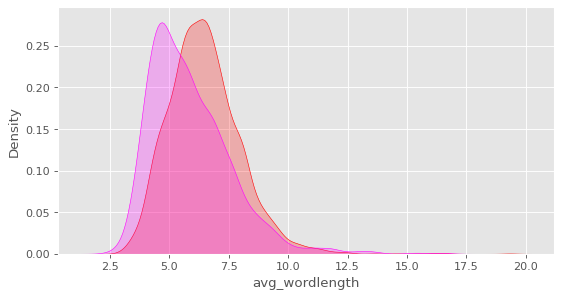

In [28]:
sns.kdeplot(tweet[tweet['target']==1]['avg_wordlength'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['avg_wordlength'], shade=True, color='magenta')


<ipython-input-29-696949065a33>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tweet[tweet['target']==1]['stopwords_counts'], shade=True, color='red')
<ipython-input-29-696949065a33>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tweet[tweet['target']==0]['stopwords_counts'], shade=True, color='magenta')


<Axes: xlabel='stopwords_counts', ylabel='Density'>

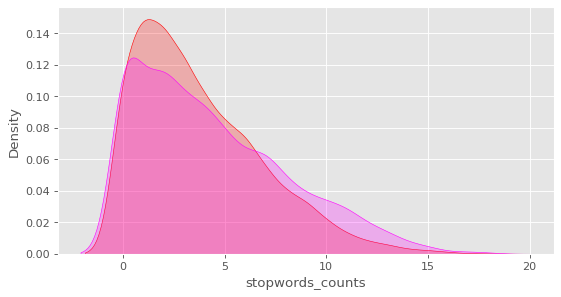

In [29]:
sns.kdeplot(tweet[tweet['target']==1]['stopwords_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['stopwords_counts'], shade=True, color='magenta')


In [30]:
tweet.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'char_counts',
       'word_counts', 'avg_wordlength', 'stopwords_counts', 'hashtag_counts',
       'mentions_counts', 'digits_counts', 'uppercase_counts'],
      dtype='object')

In [31]:
#most and least common words
freqs = pp.get_word_freqs(tweet,'text')
top20 = freqs[100:120]

In [32]:
freqs.head()

the    2575
a      1845
to     1805
in     1757
of     1722
dtype: int64

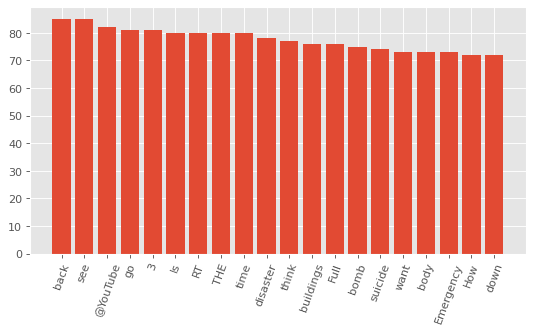

In [33]:
plt.bar(top20.index, top20.values)
plt.xticks(rotation=70)
plt.show()

In [34]:
least20 = freqs[-20:]
least20

http://t.co/JD7rIK7fX0     1
ft.åÊM.O.P.                1
http://t.co/ZDTz3RbS6w     1
'Detonate.'                1
@ApolloBrown's             1
PLAY                       1
missed.                    1
detonate&amp;Shots         1
succeed                    1
marines                    1
@BBCTalkback               1
@rfcgeom66                 1
@tomfromireland            1
@SourMashNumber7           1
#FIYA!                     1
https://t.co/NlJVP3Vfyz    1
(Ft.                       1
Dix                        1
bandolier                  1
http://t.co/YmY4rSkQ3d     1
dtype: int64

In [35]:
bigram = pp.get_ngram(tweet, 'text', ngram_range=2)

In [36]:
bigram[-20:]

[('00end date', 19),
 ('0000 utc', 18),
 ('000 riot', 17),
 ('000 people', 16),
 ('000 gems', 15),
 ('00 white', 14),
 ('00 tonight', 13),
 ('00 to', 12),
 ('00 thursday', 11),
 ('00 thread', 10),
 ('00 pm', 9),
 ('00 in', 8),
 ('00 http', 7),
 ('00 hiroshima', 6),
 ('00 bestseller', 5),
 ('00 at', 4),
 ('00 am', 3),
 ('00 52', 2),
 ('00 25', 1),
 ('00 11', 0)]

#### One shot data cleaning

In [37]:
def get_clean(x):
  x= str(x).lower().replace('\\',' ').replace('.',' ')
  x = pp.cont_exp(x)
  x = pp.remove_emails(x)
  x = pp.remove_urls(x)
  x = pp.remove_html_tags(x)
  x = pp.remove_rt(x)
  x = pp.remove_accented_chars(x)
  x = pp.remove_special_chars(x)
  x = pp.remove_dups_char(x)

  return x

In [39]:
tweet['text'] = tweet['text'].apply(lambda x: get_clean(x))

/usr/local/lib/python3.10/dist-packages/preprocess_kgptalkie/utils.py:97: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(x, 'lxml').get_text().strip()


In [40]:
tweet.head()['text']

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    130 people receive wildfires evacuation orders...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

#### disaster words visualization with word cloud

In [41]:
real = pp.get_word_freqs(tweet[tweet['target']==1], 'text')
real = ' '.join(real.index)
real

'httpt the in of a to and is on for i at by from it that with not you after this fire was are as have my news httpst over up more via an disaster were be people california suicide has no police who but when been killed like do will 2 hiroshima just than so out fires storm crash families we train about into now emergency s your buildings bomb all there mh370 what two they am nuclear attack wildfire video accident get one bombing minister burning northern new prime how legionnaires dead me bomber if some homes war car atomic still obama he fatal years off us forest collapse debris may watch city first malaysia japan man latest mass 1 or retweet near water severe today had earthquake those confirmed before would oil found 70 floods spill world army down home under warning 3 derailment wreckage outbreak weather injured evacuation 4 could being 40 saudi thunderstorm migrants old our can flooding during flood say missing investigators their time bridge back state death mosque her suspect kil

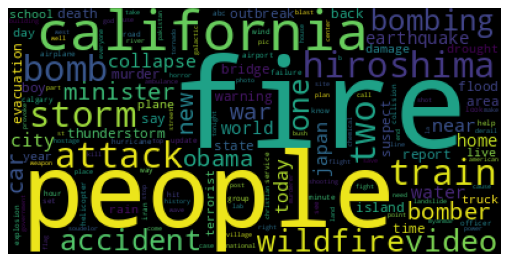

In [42]:
word_cloud = WordCloud(max_font_size=100).generate(real)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

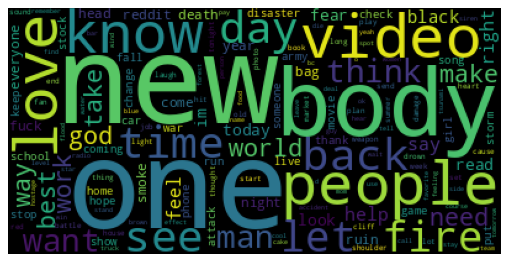

In [43]:
# not real plot

nreal = kgp.get_word_freqs(tweet[tweet['target']==0], 'text')
nreal = ' '.join(nreal.index)
word_cloud = WordCloud(max_font_size=100).generate(nreal)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

### Classification with TFID and SVM

In [44]:
text = tweet['text']
y = tweet['target']

In [46]:
tfidf = TfidfVectorizer()
x = tfidf.fit_transform(text)

In [47]:
x.shape

(7613, 22539)

In [49]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

In [50]:
def run_SVM(clf, X_train, X_test, y_train, y_test):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  print()
  print('Classification Report')
  print(classification_report(y_test, y_pred))

In [51]:
from sklearn.svm import LinearSVC

In [52]:
clf = LinearSVC()
run_SVM(clf, x_train, x_test, y_train, y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       869
           1       0.83      0.69      0.75       654

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523

